## Anomaly detection with autoencoders

In this notebook we you have to create a fully-connected neural network based autoencoder in order to detect credit card frauds. In the dataset there are 492 labeled frauds and 284807 normal transactions. First, let's download the dataset and unpack it (original source of the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud - before downloading the data please read and accept the licence of the original datasource):

In [1]:
# !wget https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip

In [2]:
# %%capture
# !unzip creditcardfraud.zip

## Imports
Import the necessary modules:

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD

np.random.seed(123)

In [5]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)],
)
logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


2024-05-09 19:52:50.006108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 19:52:50.020272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 19:52:50.020420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Exercise 1: Reading and preparing the data
Read the creditcard.csv into a Pandas Dataframe with the [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [6]:
df = pd.read_csv("./data/creditcard.csv")

As the next step, select all the columns of the dataframe for the input X, but the "Class" column. And select the "Class" column for output Y. Make sure that both X and Y are two dimensional Numpy arrays.

Hint:
* you can use df.loc to select rows and columns from a dataframe
* you can get the Numpy array of a Pandas object with .values, eg. df['myfeature'].values

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
Y = df["Class"].values
X = df.drop("Class", axis=1).values

In [9]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (284807, 30)
Shape of Y: (284807,)


Let's standardize the data:

In [10]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Exercise 2: defining the autoencoder
Let's define a model according to the following instructions:
* the model's inputs and outputs should be the same as the number of X's features (columns)
* the model should have 5 hidden layers, with 16-10-6-10-16 neurons in the hidden layers, respectively
* all layers but the output should have tanh activation
* the output layer should have linear activation

In [11]:
model = Sequential()

model.add(Dense(16, activation="tanh", input_shape=(X.shape[1],)))
model.add(Dense(10, activation="tanh"))
model.add(Dense(6, activation="tanh"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(16, activation="tanh"))
model.add(Dense(X.shape[1], activation="linear"))

2024-05-09 19:52:51.314625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 7.81GiB (8388608000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


## Exercise 3: define early stopping compile the model, and train it
Please pay attention to the following details:
* use EarlyStopping with patience 10 and this time monitor the training loss
* do not define validation data
* use mean squarred error loss function
* both the input and output of the model should be X this time. (as we are "auto encoding" the input to the output)

In [12]:
patience = 15
es = EarlyStopping(
    monitor="loss", patience=patience, verbose=1, restore_best_weights=True
)
model.compile(loss="mse", optimizer="adam")

In [13]:
history = model.fit(X, X, epochs=1000, callbacks=[es], batch_size=128, shuffle=True)

Epoch 1/1000


2024-05-09 19:52:52.977157: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56d73820f900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 19:52:52.977185: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-09 19:52:52.994285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-09 19:52:53.032482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-09 19:52:53.105269: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2226/2226 [==============================] - 5s 2ms/step - loss: 0.7839
Epoch 2/1000
2226/2226 [==============================] - 3s 2ms/step - loss: 0.6835
Epoch 3/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.6397
Epoch 4/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.6004
Epoch 5/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.5760
Epoch 6/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.5623
Epoch 7/1000
2226/2226 [==============================] - 3s 2ms/step - loss: 0.5520
Epoch 8/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.5427
Epoch 9/1000
2226/2226 [==============================] - 4s 2ms/step - loss: 0.5349
Epoch 10/1000
2226/2226 [==============================] - 3s 2ms/step - loss: 0.5293
Epoch 11/1000
2226/2226 [==============================] - 3s 2ms/step - loss: 0.5250
Epoch 12/1000
2226/2226 [==============================] - 3s 2ms/step - los

## Results analysis
After training is done, we make predictions for the complete dataset and inspect the reconstruction loss. Our assumption is that, higher reconstruction loss are more likely to belong to anomalies than lower reconstruciton loss.

In [14]:
preds = model.predict(X)
errs = np.square(preds - X)
errs = np.mean(errs, axis=1)

8901/8901 [==============================] - 6s 651us/step


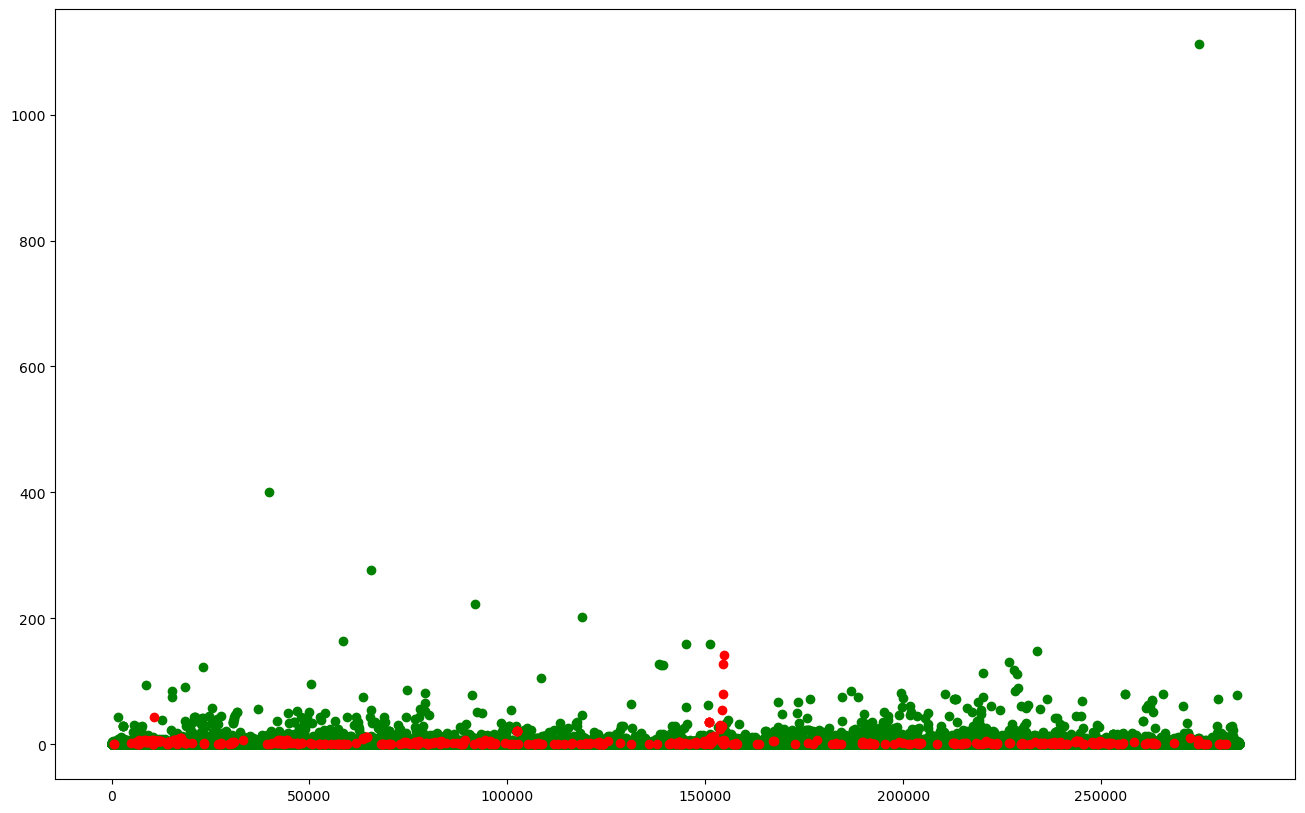

In [15]:
plt.figure(figsize=(16, 10))
rng = np.arange(len(errs))
colors = ["g", "r"]  # green: normal, red: anomaly
for i in [0, 1]:
    plt.scatter(rng[(Y == i).reshape(-1)], errs[(Y == i).reshape(-1)], color=colors[i])

In [16]:
Y_cut = Y[errs < 10]
errs_cut = errs[errs < 10]

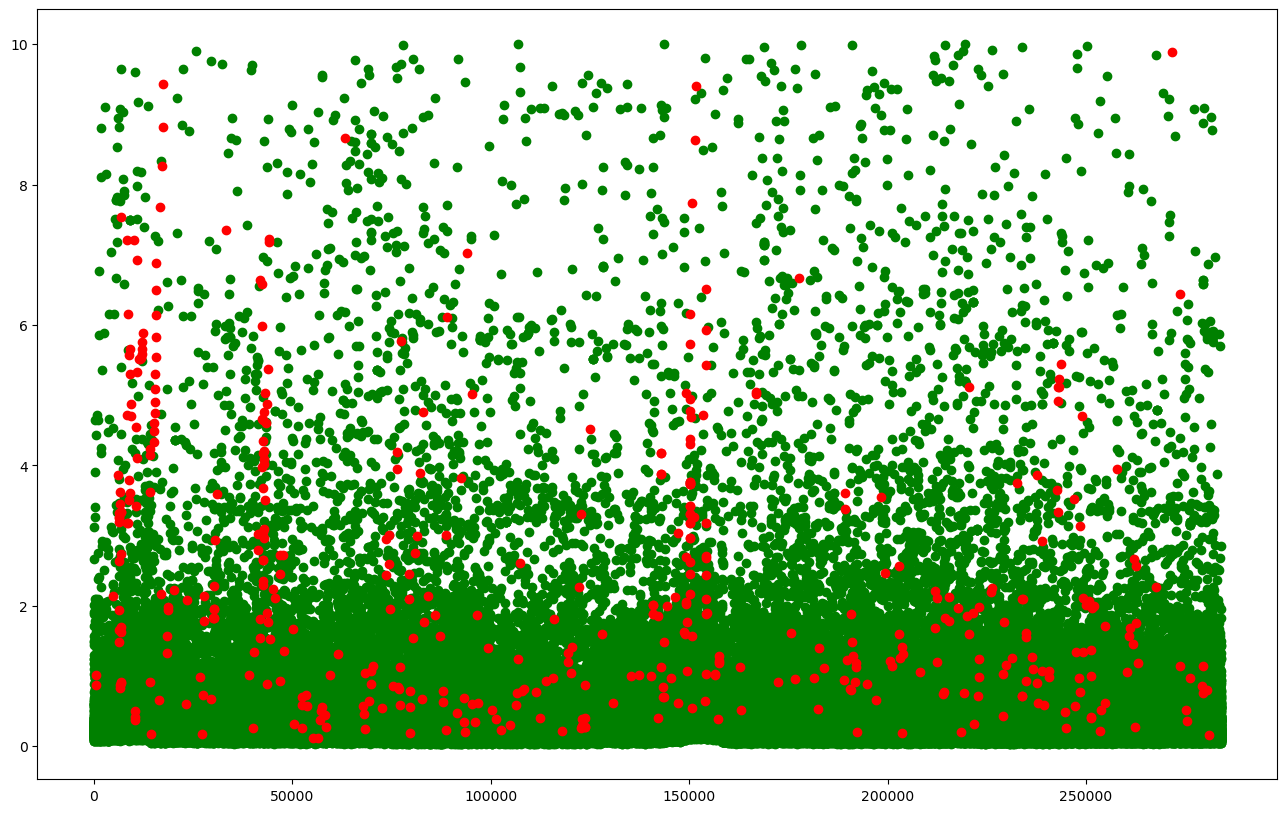

In [17]:
plt.figure(figsize=(16, 10))
rng = np.arange(len(errs_cut))
colors = ["g", "r"]
for i in [0, 1]:
    plt.scatter(
        rng[(Y_cut == i).reshape(-1)],
        errs_cut[(Y_cut == i).reshape(-1)],
        color=colors[i],
    )

## Exercise 4: finding the right treshold
Find a treshold that identifies at least 130 anomalies correctly with as small number of missclassifications of non-anomalies as possible.

In [195]:
treshold = 2.5
errs_filtered = errs[errs > treshold]
Y_filtered = Y[errs > treshold]
errs_filtered_non_anomalies = errs[errs <= treshold]
Y_filtered_non_anomalies = Y[errs <= treshold]

print("Anomalies in the dataset")  # Y_filtered==1
print("   predicted as anomaly:", len(errs_filtered[Y_filtered == 1]))
print(
    "   predicted as non-anomaly: ",
    len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 1]),
)
print("Non-anomalies in the dataset")  # Y_filtered ==0
print("   predicted as anomaly:", len(errs_filtered[Y_filtered == 0]))
print(
    "   predicted as non-anomaly:",
    len(errs_filtered_non_anomalies[Y_filtered_non_anomalies == 0]),
)

Anomalies in the dataset
   predicted as anomaly: 203
   predicted as non-anomaly:  289
Non-anomalies in the dataset
   predicted as anomaly: 3826
   predicted as non-anomaly: 280489


We can also inspect the confusion matrix:

<Axes: >

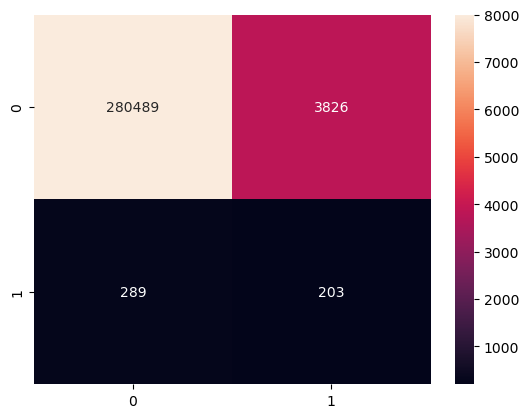

In [196]:
conf = confusion_matrix(Y, errs > treshold)
sns.heatmap(conf, annot=True, vmax=8000, fmt="d")

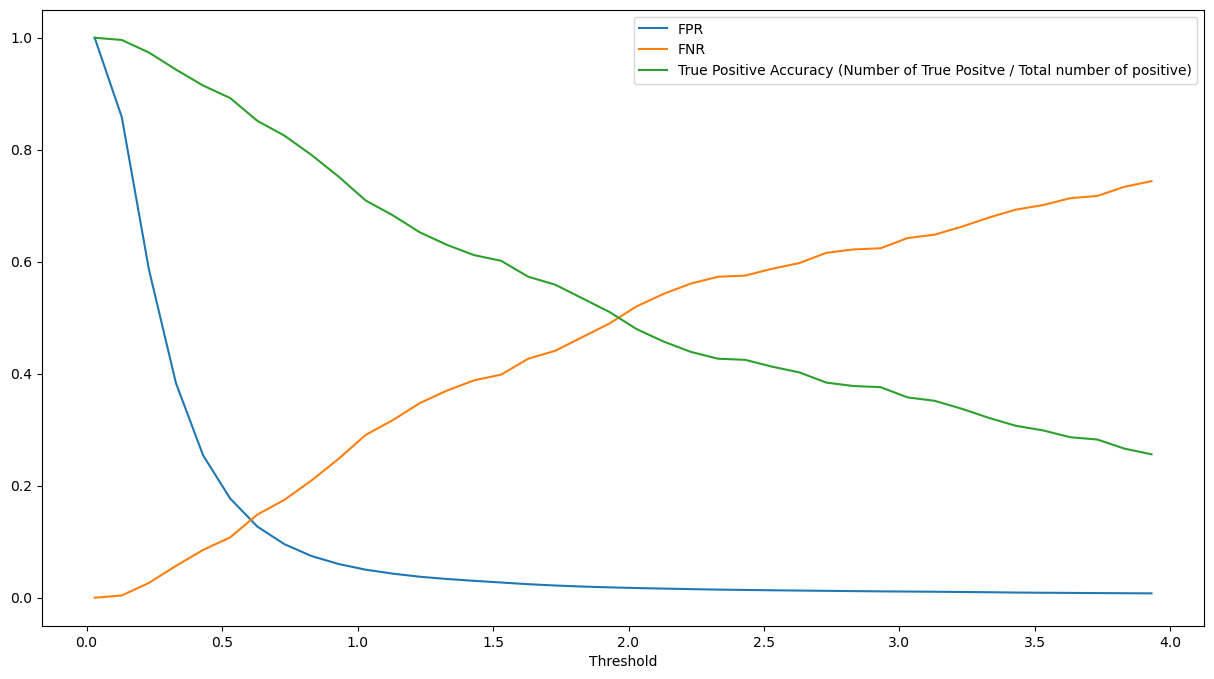

In [192]:
from math import ceil
from collections import Counter


threshold_vals = [round(min(errs) + mult * 0.1, 2) for mult in range(0, 40)]
fpr = []
fnr = []
tp_acc = []
true_pos = []
num_true_pos = Counter(Y)[1]
for thres in threshold_vals:
    conf = confusion_matrix(Y, errs > thres)
    tn, fp = conf[0]
    fn, tp = conf[1]
    fpr.append(fp/(fp+tn))
    fnr.append(fn/(fn+tp))
    tp_acc.append(tp/num_true_pos)
    true_pos.append(tp)

plt.figure(figsize=(15, 8))

plt.plot(threshold_vals, fpr, label="FPR")
plt.plot(threshold_vals, fnr, label="FNR")
plt.plot(threshold_vals, tp_acc, label="True Positive Accuracy (Number of True Positve / Total number of positive)")
plt.xlabel("Threshold")
plt.legend()

Thus based on the graph, we can choose a threshold from 2 to 3.5 to satisfy our requirements.